# Exploring the effect of shifting baseline

### Data used in this analysis: ESPO-G6-E5L v1.0.0, ERA5-Land Hourly 
<br>ERA5 (Reanalyzed data): Combine model data with observation for assimilation. Thus creating improved version of orignial observations.
<br>For more information: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview
<br><br>ESPO-G6-E5L v1.0.0 (Model data): An ensemble of bias-adjusted CMIP6 climate simulations on North America. 
<Br>For more information: https://github.com/Ouranosinc/ESPO-G

Source: 
<br><br>Lavoie, J., Bourgault, P., Logan, T., Caron, L.-P., Gammon, S., Smith, T. J., Biner, S., & Leduc, M. (2023). ESPO-G6-E5L : Ensemble de Simulations Post-traitées d'Ouranos - modèles Globaux CMIP6 - ERA5-Land / Ouranos Ensemble of Bias-adjusted Simulations - Global Models CMIP6 - ERA5-Land (ESPO-G6-E5Lv1.0.0). Zenodo. https://doi.org/10.5281/zenodo.7764929
<br><br>Muñoz Sabater, J. (2019): ERA5-Land hourly data from 1950 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.e2161bac  (Accessed on 21-May-2024)

### Load packages

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.stats as st
from pathlib import Path
import cftime as cf
import matplotlib as mpl
import seaborn as sns
mpl.rc('font',size=14)

## Read in model and renalysis data
Create dictionaries for storage

In [2]:
# Variables for cities
folders=['Calgary','GTA','Halifax','Montreal','Vancouver']
sub_folders=['CAL','GTA','HAL','MON','VAN']
# Create dictonaries
raw_data_245={}
raw_data_370={}
raw_ensemble_ssp245={}
raw_ensemble_ssp370={}
raw_era_data={}
maps={}

In [3]:
for fol,sub_f in zip(folders,sub_folders):
    print(fol,'start')
# Individual models
    # raw_data_245[fol]={file.stem :xr.open_dataset(file,drop_variables=['pr','tasmax','tasmin'],chunks={'time':-1}) for file in Path('C:/Users/edmun/Documents/UOFT/summer_intern/data_raw/model_data/'+fol+'/ssp245/').glob('*.nc')}
    # raw_data_370[fol]={file.stem :xr.open_dataset(file,drop_variables=['pr','tasmax','tasmin'],chunks={'time':-1}) for file in Path('C:/Users/edmun/Documents/UOFT/summer_intern/data_raw/model_data/'+fol+'/ssp370/').glob('*.nc')}

# Ensemble
    raw_ensemble_ssp245[fol]=xr.open_mfdataset('C:/Users/edmun/Documents/UOFT/summer_intern/data_raw/model_data/'+fol+'/ssp245/*.nc',drop_variables=['pr','tasmax','tasmin'],combine='nested',concat_dim='model',chunks={"time":-1,'model':-1})
    raw_ensemble_ssp370[fol]=xr.open_mfdataset('C:/Users/edmun/Documents/UOFT/summer_intern/data_raw/model_data/'+fol+'/ssp370/*.nc',drop_variables=['pr','tasmax','tasmin'],combine='nested',concat_dim='model',chunks={"time":-1,'model':-1})
# ERA5 data
    raw_era_data[fol]=xr.open_mfdataset('C:/Users/edmun/Documents/UOFT/summer_intern/data_raw/model_data/'+fol+'/era5_*/era5_land_'+sub_f+'/*.nc',chunks={"time":-1})

# Load map of each city
    maps[fol]=[gpd.read_file(file) for file in Path('C:/Users/edmun/Documents/UOFT/summer_intern/github/maps/'+sub_f+'/').glob('*.shp')]

Calgary start
GTA start
Halifax start
Montreal start
Vancouver start


## Data Transformation

In [4]:
# Create empty dictionary
era_data_modified={}
for fol in folders:
    print(fol,'start')
# Convert ERA5-Land data datetime
    era_data_modified[fol]=raw_era_data[fol].convert_calendar('360_day',align_on='date')
# Convert to daily data
    era_data_modified[fol]=era_data_modified[fol].resample(time='1D').mean('time')-273.15
# Finally we will have to regrid to match the model data
    era_data_modified[fol]=era_data_modified[fol].interp(latitude=raw_ensemble_ssp245[fol].lat,longitude=raw_ensemble_ssp245[fol].lon)

Calgary start
GTA start
Halifax start
Montreal start
Vancouver start


#### Now check the modified ERA5 data

# Clipping

<br>Source: Land Information Ontario. Topographic Map Maker [digital resource: raster]. Greater Toronto Area (GTA) 2013 Orthophotography
. Retrieved 05-27-2024, from https://www.arcgis.com/home/item.html?id=9ed81541fead4f5ba9b497d92df42f41.
<br><br>
Statistics Canada. (2021) 2021 Census – Boundary files [Data set]. Retrieved 05-15-2024, from https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-eng.cfm?year=21.

In [5]:
def clipping(dataset,city):
    shp=[gpd.read_file(file) for file in Path('C:/Users/edmun/Documents/UOFT/summer_intern/github/maps/'+city+'/').glob('*.shp')]
    data_clipped=dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
    data_clipped=data_clipped.rio.write_crs("epsg:4326")
    data_clipped=data_clipped.rio.clip(shp[0].geometry.values,shp[0].crs, drop = False, invert = False)
    return data_clipped


In [8]:
ensemble_245_clipped={}
ensemble_370_clipped={}
raw_data_245_clipped={}
raw_data_370_clipped={}
era_clipped={}
for fol,sub_f in zip(folders,sub_folders):
    print(fol,'start')
    ensemble_245_clipped[fol]=clipping(raw_ensemble_ssp245[fol],sub_f)
    ensemble_370_clipped[fol]=clipping(raw_ensemble_ssp370[fol],sub_f)
    era_clipped[fol]=clipping(era_data_modified[fol],sub_f)
    # raw_data_245_clipped[fol]={}
    # raw_data_370_clipped[fol]={}
    # for key in raw_data_245[fol].keys():
    #     raw_data_245_clipped[fol][key]=clipping(raw_data_245[fol][key],sub_f)
    # for key in raw_data_370[fol].keys():
    #     raw_data_370_clipped[fol][key]=clipping(raw_data_370[fol][key],sub_f)

Calgary start
GTA start
Halifax start
Montreal start
Vancouver start


# Assessing future 

## Temperature Normals

Tri-decadal period (2021 - 2050 , 2051 - 2080, 2081 - 2100)

In [9]:
# define periods
years=[2021,2051,2071]

# Create dictionaries
# d: daily m: monthly
ensemble_245_normal_m={}
ensemble_245_normal_d={}
ensemble_245_annual={}
ensemble_245={}
ensemble_370_normal_m={}
ensemble_370_normal_d={}
ensemble_370_annual={}
ensemble_370={}
baseline={}
baseline_annual={}
baseline_normal_m={}
baseline_normal_d={}
for city in folders:
    print(city)
    ensemble_245[city]={}
    ensemble_370[city]={}
    ensemble_245_normal_m[city]={}
    ensemble_370_normal_m[city]={}
    ensemble_245_normal_d[city]={}
    ensemble_370_normal_d[city]={}
    ensemble_245_annual[city]={}
    ensemble_370_annual[city]={}
# Baseline
    baseline[city]=era_clipped[city].sel(time=slice('1991-01-01','2020-12-30')).mean(['lat','lon']).t2m
# Annual
    baseline_annual[city]=baseline[city].groupby('time.year').mean(['time'])
# Daily Normals
    baseline_normal_d[city]=baseline[city].groupby('time.dayofyear').mean(['time'])

# Monthly Normals
    baseline_normal_m[city]=baseline[city].groupby('time.month').mean(['time'])
    for year in years:
        year_start=str(year)
        year_end=str(year+29)
# Slicing 
        ensemble_245[city][year_start+'_'+year_end]=ensemble_245_clipped[city].sel(time=slice(year_start+'-01-01',
                                                     year_end+'-12-30')).mean(['lat','lon'])
        ensemble_370[city][year_start+'_'+year_end]=ensemble_370_clipped[city].sel(time=slice(year_start+'-01-01',
                                                     year_end+'-12-30')).mean(['lat','lon'])
# Daily Normals    
        ensemble_245_normal_d[city][year_start+'_'+year_end]=ensemble_245[city][year_start+'_'+year_end].groupby('time.dayofyear').mean(['time'])
        ensemble_370_normal_d[city][year_start+'_'+year_end]=ensemble_370[city][year_start+'_'+year_end].groupby('time.dayofyear').mean(['time'])

# Monthly Normals
        ensemble_245_normal_m[city][year_start+'_'+year_end]=ensemble_245[city][year_start+'_'+year_end].groupby('time.month').mean(['time'])
        ensemble_370_normal_m[city][year_start+'_'+year_end]=ensemble_370[city][year_start+'_'+year_end].groupby('time.month').mean(['time'])

# Annual temperature
        ensemble_245_annual[city][year_start+'_'+year_end]=ensemble_245[city][year_start+'_'+year_end].groupby('time.year').mean(['time'])
        ensemble_370_annual[city][year_start+'_'+year_end]=ensemble_370[city][year_start+'_'+year_end].groupby('time.year').mean(['time'])

    

Calgary
GTA
Halifax
Montreal
Vancouver


Calgary


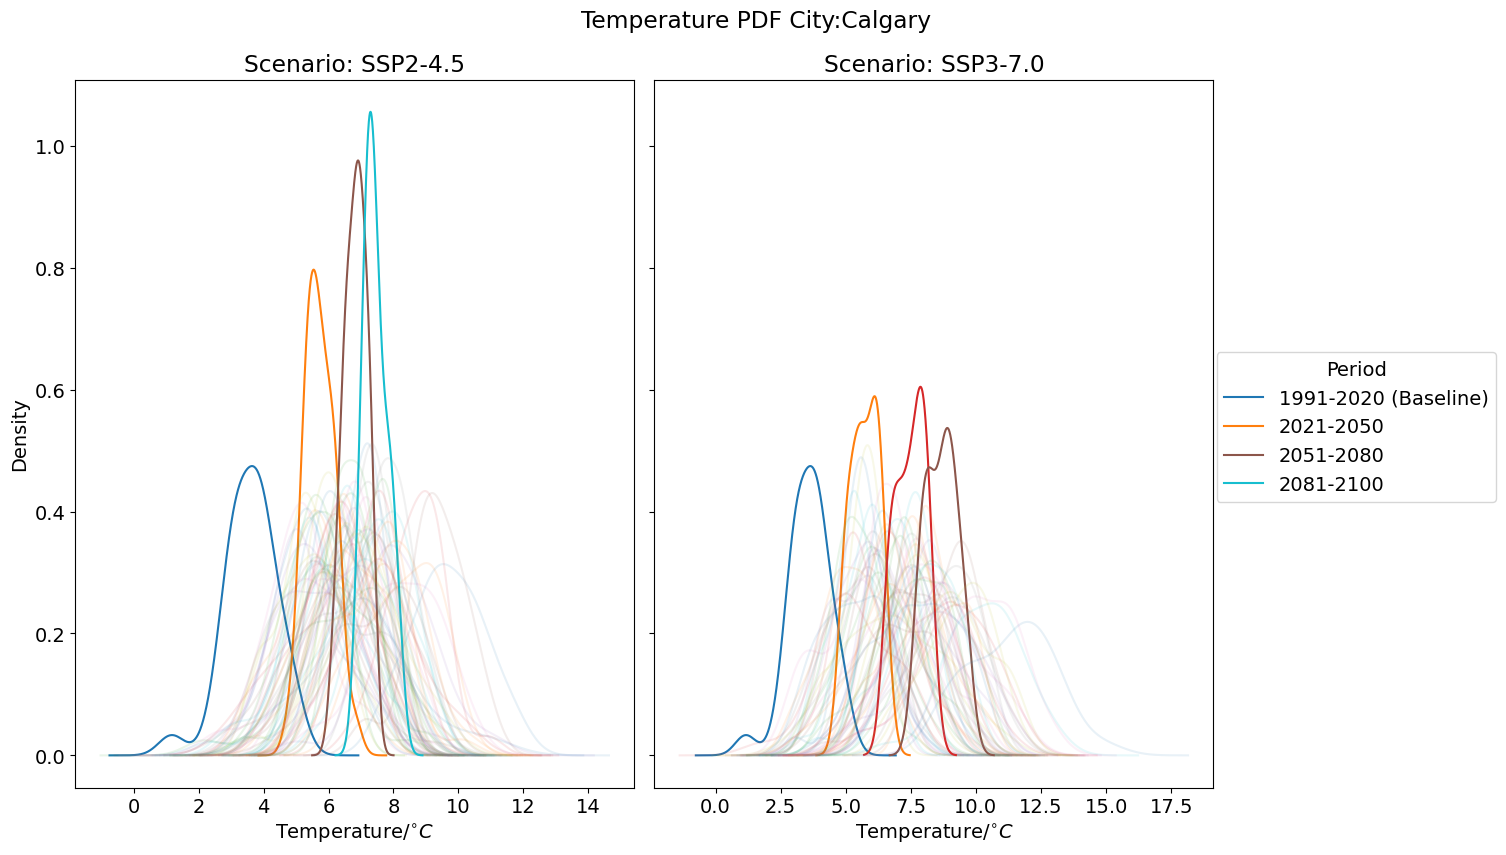

In [40]:
# Annual Mean Temperature PDF for cities and scenarios
for city in folders[0:1]:
    print(city)
    fig,ax=plt.subplots(1,2,figsize=(15,8),layout='constrained',sharey=True)
    fig.suptitle('Temperature PDF City:'+city,y=1.05)
# Baseline
    baseline_annual[city].to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[0],legend=False)
    baseline_annual[city].to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[1],legend=False)
# Ensemble    
    for period in ensemble_245_annual[city].keys():
        ensemble_245_annual[city][period].mean(['model']).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[0],legend=False)
        ensemble_370_annual[city][period].mean(['model']).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[1],legend=False)
# Individual models
        for i in ensemble_245_annual[city][period].model:
            ensemble_245_annual[city][period].sel(model=i).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.kde(ax=ax[0],alpha=0.2,legend=False)
        for i in ensemble_370_annual[city][period].model:
            ensemble_370_annual[city][period].sel(model=i).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.kde(ax=ax[1],alpha=0.2,legend=False)
# Labels
    ax[0].set_xlabel('Temperature/$^{\circ}C$')
    ax[1].set_xlabel('Temperature/$^{\circ}C$')
    h,l = ax[0].get_legend_handles_labels()
    ax[0].set_title('Scenario: SSP2-4.5')
    ax[1].set_title('Scenario: SSP3-7.0')
    fig.legend([h[0],h[1],h[25],h[49]],['1991-2020 (Baseline)','2021-2050','2051-2080','2081-2100'],title='Period', loc='outside right')
    # ax[0].legend([h[0],h[1],h[25],h[49]],['Baseline 1991-2020','2021-2050','2051-2080','2081-2100'],title='Period')
    # ax[1].legend([h1[0],h1[1],h1[23],h1[47]],['Baseline 1991-2020','2021-2050','2051-2080','2081-2100'],title='Period')
    

Calgary


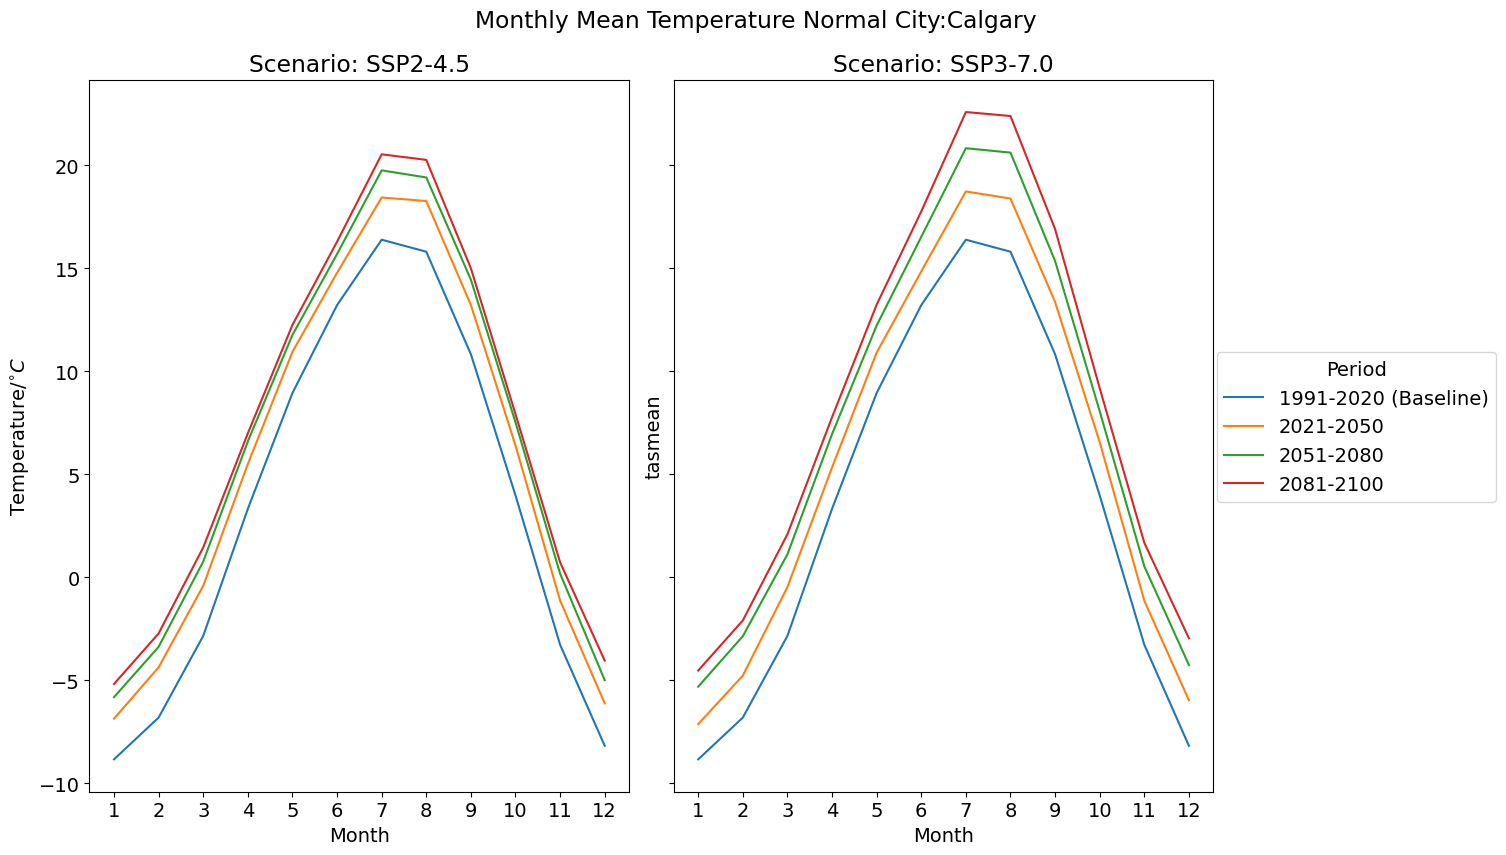

In [42]:
for city in folders[0:1]:
    print(city)
    fig,ax=plt.subplots(1,2,figsize=(15,8),layout='constrained',sharey=True,sharex=True)
    fig.suptitle('Monthly Mean Temperature Normal City:'+city,y=1.05)
    baseline_normal_m[city].plot(ax=ax[0])
    baseline_normal_m[city].plot(ax=ax[1])
    for period in ensemble_245_normal_m[city].keys():
        ensemble_245_normal_m[city][period].mean(['model']).tasmean.plot(ax=ax[0])
        ensemble_370_normal_m[city][period].mean(['model']).tasmean.plot(ax=ax[1])
    ax[0].set_ylabel('Temperature/$^{\circ}C$')
    ax[1].set_ylabel('')
    ax[0].set_xticks(np.arange(1,13,1),np.arange(1,13,1))
    ax[1].set_xticks(np.arange(1,13,1),np.arange(1,13,1))
    ax[0].set_xlabel('Month')
    ax[1].set_xlabel('Month')
    ax[0].set_title('Scenario: SSP2-4.5')
    ax[1].set_title('Scenario: SSP3-7.0')
    fig.legend(['1991-2020 (Baseline)','2021-2050','2051-2080','2081-2100'],title='Period', loc='outside right')
    

# Shifting Baseline

<br><br>The projection of temperature above is computed with a stationary baseline, which means the 30-year reference period remains the same for the entire time series. Now, we will look at the impact of shifting baseline, which means the reference period will be moving along with the projection for every decade.
<br><br>For example:
| Time Period of Interest | 2021 - 2050 | 2051 - 2080 | 2081 - 2100
| --- | --- | --- | --- |
| Stationary Baseline | 1991 - 2020 | 1991 - 2020 | 1991 - 2020 |
| Shifting Baseline | 2011 - 2040 | 2041 - 2070 | 2071 - 2090 |

In [20]:
# Function generate shifting and stationary baseline temperature anomalies
def create_baseline(model,city,method='shifting'): #The default method for this function would be shifting baseline 
     # for shifting baseline
     if method=='shifting':
          data=model[city].tasmean.sel(time=slice('1960-01-01','2100-12-30'))-model[city].tasmean.sel(time=slice('1950-01-01','2090-12-30')).to_numpy()
     # for stationary baseline:
     elif method=='stationary':
          # let's create a array with the baseline
          baseline_mean=baseline[city].mean().values
          series=model[city].tasmean.sel(time=slice('1960-01-01','2100-12-30'))
          data=series-baseline_mean
     return data

In [21]:
# Create dictionaries
shifted_245={}
shifted_370={}
stat_245={}
stat_370={}
# Create time series
for city in folders:
    shifted_245[city]=create_baseline(ensemble_245_clipped,city)
    stat_245[city]=create_baseline(ensemble_245_clipped,city,'stationary')
    shifted_370[city]=create_baseline(ensemble_370_clipped,city)
    stat_370[city]=create_baseline(ensemble_370_clipped,city,'stationary')
    print(city,'done')

Calgary done
GTA done
Halifax done
Montreal done
Vancouver done


In [50]:
# Create dictionaries
shifted_245_norm_m={}
shifted_245_norm_d={}
shifted_245_annual={}
shifted_370_norm_m={}
shifted_370_norm_d={}
shifted_370_annual={}
stat_245_norm_m={}
stat_245_norm_d={}
stat_245_annual={}
stat_370_norm_m={}
stat_370_norm_d={}
stat_370_annual={}
# Compute normals
for city in folders:
    print(city)
    shifted_245_norm_m[city]={}
    shifted_245_norm_d[city]={}
    shifted_245_annual[city]={}
    shifted_370_norm_m[city]={}
    shifted_370_norm_d[city]={}
    shifted_370_annual[city]={}
    stat_245_norm_m[city]={}
    stat_245_norm_d[city]={}
    stat_245_annual[city]={}
    stat_370_norm_m[city]={}
    stat_370_norm_d[city]={}
    stat_370_annual[city]={}
# Sliced into tri-decadal periods
    for year in years:
        year_start=str(year)
        year_end=str(year+29)
        
# Shifiting SSP2-4.5
        shifted_245_annual[city][year_start+'_'+year_end]=shifted_245[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.year').mean(['time','lat','lon'])
        shifted_245_norm_d[city][year_start+'_'+year_end]=shifted_245[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.dayofyear').mean(['time','lat','lon'])
        shifted_245_norm_m[city][year_start+'_'+year_end]=shifted_245[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.month').mean(['time','lat','lon'])
        
# Shifting SSP3-7.0
        shifted_370_annual[city][year_start+'_'+year_end]=shifted_370[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.year').mean(['time','lat','lon'])
        shifted_370_norm_d[city][year_start+'_'+year_end]=shifted_245[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.dayofyear').mean(['time','lat','lon'])
        shifted_370_norm_m[city][year_start+'_'+year_end]=shifted_370[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.month').mean(['time','lat','lon'])
        
# Stationary SSP2-4.5
        stat_245_annual[city][year_start+'_'+year_end]=stat_245[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.year').mean(['time','lat','lon'])
        stat_245_norm_d[city][year_start+'_'+year_end]=stat_245[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.dayofyear').mean(['time','lat','lon'])
        stat_245_norm_m[city][year_start+'_'+year_end]=stat_245[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.month').mean(['time','lat','lon'])

# Stationary SSP3-7.0
        stat_370_annual[city][year_start+'_'+year_end]=stat_370[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.year').mean(['time','lat','lon'])
        stat_370_norm_d[city][year_start+'_'+year_end]=stat_370[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.dayofyear').mean(['time','lat','lon'])
        stat_370_norm_m[city][year_start+'_'+year_end]=stat_370[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.month').mean(['time','lat','lon'])       

Calgary
GTA
Halifax
Montreal
Vancouver


Calgary


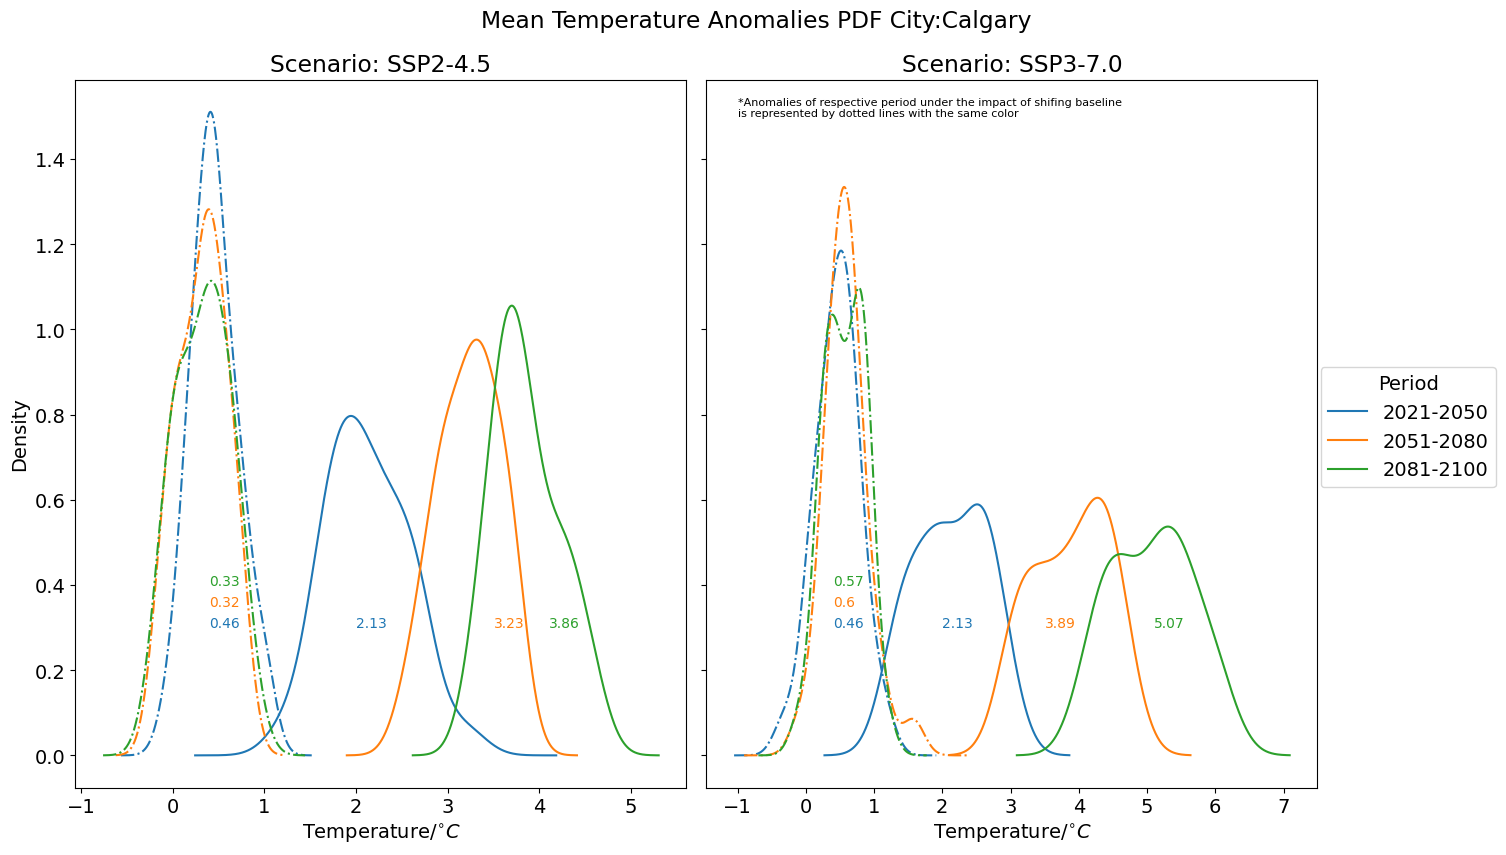

In [87]:
# Annual Mean Temperature PDF for cities and scenarios
colors = ['#1f77b4','#ff7f0e','#2ca02c']
y_m=[0.3,0.35,0.4]
x0s=[2,3.5,4.1]
x1s=[2,3.5,5.1]
for city in folders[0:1]:
    print(city)
    fig,ax=plt.subplots(1,2,figsize=(15,8),layout='constrained',sharey=True)
    fig.suptitle('Mean Temperature Anomalies PDF City:'+city,y=1.05)
# Shifting vs Stationary Baseline    
    for period,color,ym,x0,x1 in zip(shifted_245_annual[city].keys(),colors,y_m,x0s,x1s):
        shifted_245_annual[city][period].mean(['model']).to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[0],legend=False,ls='-.',c=color)
        stat_245_annual[city][period].mean(['model']).to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[0],legend=False,c=color)
        shifted_370_annual[city][period].mean(['model']).to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[1],legend=False,ls='-.',c=color)
        stat_370_annual[city][period].mean(['model']).to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[1],legend=False,c=color)

# Tri-decadal Mean
        ax[0].text(0.4,ym,np.round(shifted_245_annual[city][period].mean(['model','year']).values,2),c=color,fontsize=10)
        ax[0].text(x0,0.3,np.round(stat_245_annual[city][period].mean(['model','year']).values,2),c=color,fontsize=10)
        ax[1].text(0.4,ym,np.round(shifted_370_annual[city][period].mean(['model','year']).values,2),c=color,fontsize=10)
        ax[1].text(x1,0.3,np.round(stat_370_annual[city][period].mean(['model','year']).values,2),c=color,fontsize=10)
# # Individual models
#         for i in shifted_245_annual[city][period].model:
#             shifted_245_annual[city][period].sel(model=i).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.kde(ax=ax[0],alpha=0.2,legend=False)
#         for i in ensemble_370_annual[city][period].model:
#             shifted_370_annual[city][period].sel(model=i).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.kde(ax=ax[1],alpha=0.2,legend=False)
# Labels
    ax[0].set_xlabel('Temperature/$^{\circ}C$')
    ax[1].set_xlabel('Temperature/$^{\circ}C$')
    h,l = ax[0].get_legend_handles_labels()
    ax[0].set_title('Scenario: SSP2-4.5')
    ax[1].set_title('Scenario: SSP3-7.0')
    ax[1].text(-1, 1.5, '*Anomalies of respective period under the impact of shifing baseline \nis represented by dotted lines with the same color',fontsize=8)
    fig.legend([h[1],h[3],h[5]],['2021-2050','2051-2080','2081-2100'],title='Period', loc='outside right')

In [25]:
# Again, we have to rechunk the data 
shifted_ssp245_rechunk=shifted_245.chunk(chunks={'year':-1,'model':-1})
stat_ssp245_rechunk=stat_245.chunk(chunks={'year':-1,'model':-1})

shifted_ssp370_rechunk=shifted_370.chunk(chunks={'year':-1,'model':-1})
stat_ssp370_rechunk=stat_370.chunk(chunks={'year':-1,'model':-1})

# Again, compute the 10th and 90th quantiles
shifted_245_90=shifted_ssp245_rechunk.quantile(0.9,dim=['model']).compute()
shifted_245_10=shifted_ssp245_rechunk.quantile(0.1,dim=['model']).compute()

stat_245_90=stat_ssp245_rechunk.quantile(0.9,dim=['model']).compute()
stat_245_10=stat_ssp245_rechunk.quantile(0.1,dim=['model']).compute()

shifted_370_90=shifted_ssp370_rechunk.quantile(0.9,dim=['model']).compute()
shifted_370_10=shifted_ssp370_rechunk.quantile(0.1,dim=['model']).compute()

stat_370_90=stat_ssp370_rechunk.quantile(0.9,dim=['model']).compute()
stat_370_10=stat_ssp370_rechunk.quantile(0.1,dim=['model']).compute()

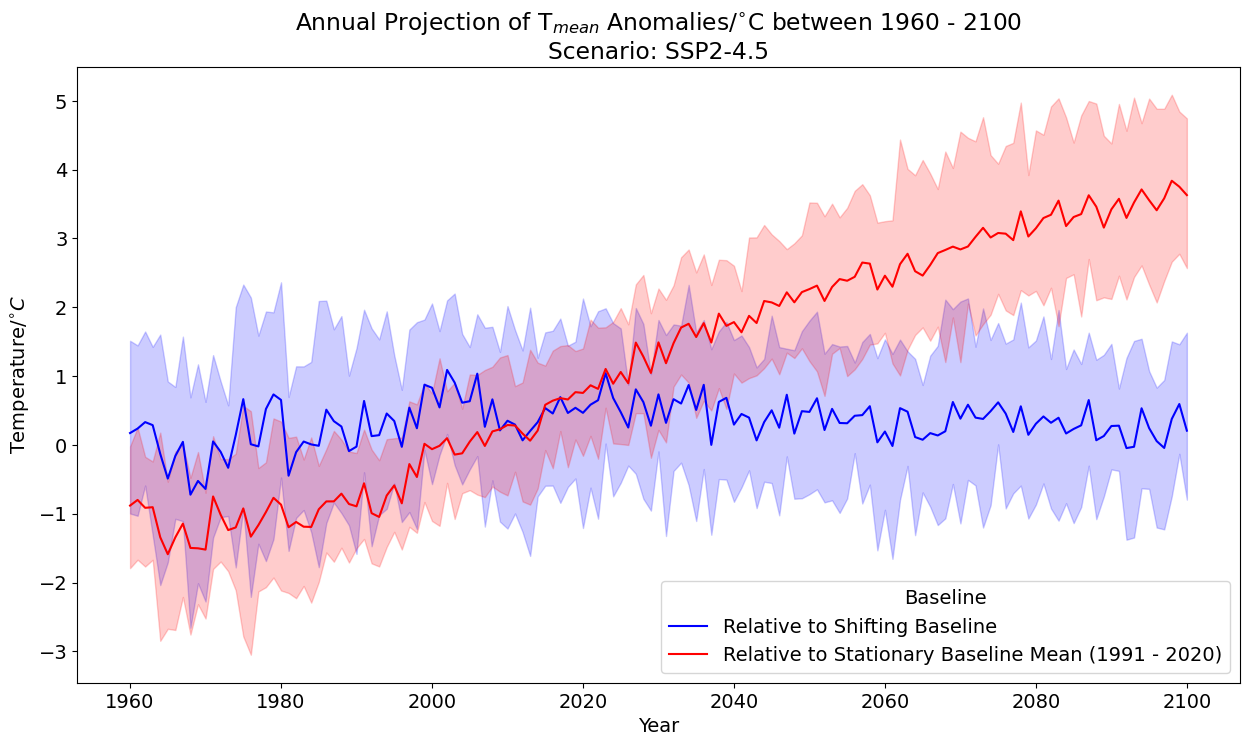

In [26]:
# plot the projection time series
fig,ax=plt.subplots(figsize=(15,8))
# Shifted Baseline
shifted_245.mean(dim='model').plot(ax=ax,color='b',label='Relative to Shifting Baseline')
# Stationary Baseline
stat_245.mean(dim='model').plot(ax=ax,color='r',label='Relative to Stationary Baseline Mean (1991 - 2020)')
# Shade the region between 10th and 90th 
ax.fill_between(shifted_245.year,shifted_245_10,shifted_245_90,alpha=0.2,color='b')
ax.fill_between(shifted_245.year,stat_245_10,stat_245_90,alpha=0.2,color='r')
# Labels and legends
ax.set_title('Annual Projection of T$_{mean}$ Anomalies/$^{\circ}$C between 1960 - 2100\nScenario: SSP2-4.5')
ax.set_ylabel('Temperature/$^{\circ}C$')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(1960,2120,20),np.arange(1960,2120,20))
ax.legend(loc=4,title='Baseline')

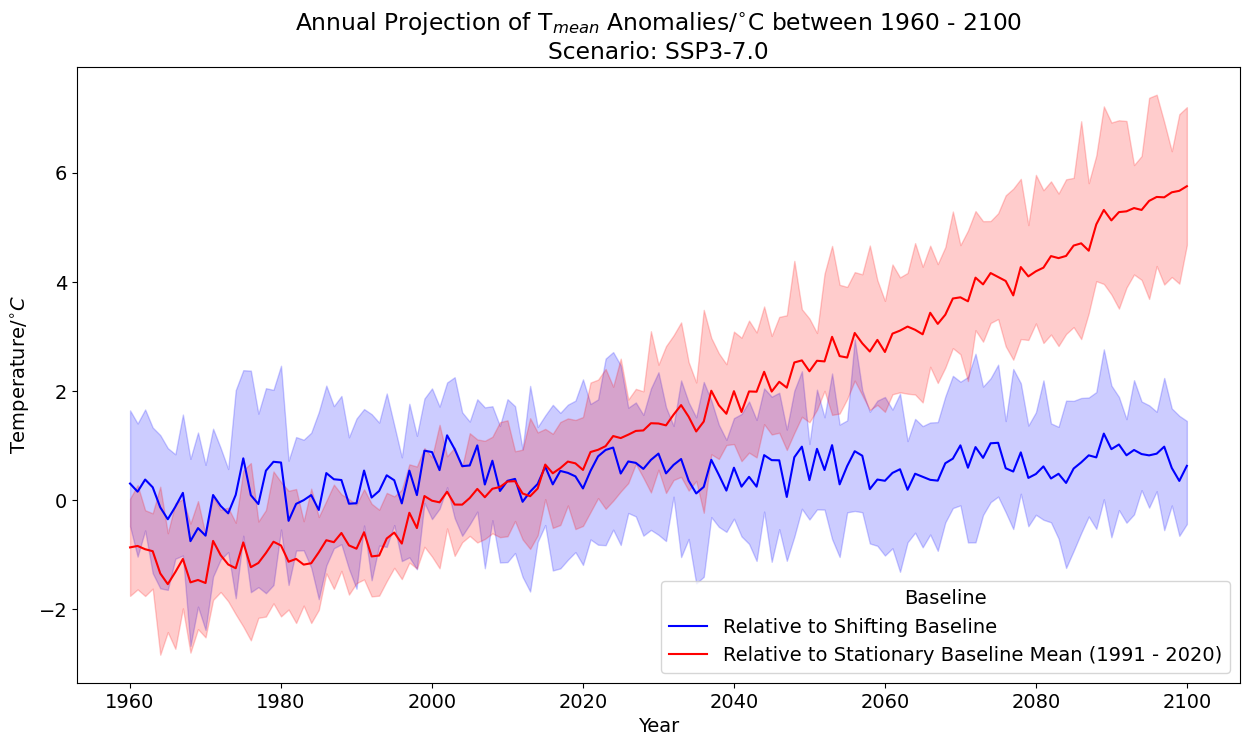

In [27]:
# plot the projection time series
fig,ax=plt.subplots(figsize=(15,8))
# Shifted Baseline
shifted_370.mean(dim='model').plot(ax=ax,color='b',label='Relative to Shifting Baseline')
# Stationary Baseline
stat_370.mean(dim='model').plot(ax=ax,color='r',label='Relative to Stationary Baseline Mean (1991 - 2020)')
# Shade the region between 10th and 90th 
ax.fill_between(shifted_370.year,shifted_370_10,shifted_370_90,alpha=0.2,color='b')
ax.fill_between(shifted_370.year,stat_370_10,stat_370_90,alpha=0.2,color='r')
# Labels and legends
ax.set_title('Annual Projection of T$_{mean}$ Anomalies/$^{\circ}$C between 1960 - 2100\nScenario: SSP3-7.0')
ax.set_ylabel('Temperature/$^{\circ}C$')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(1960,2120,20),np.arange(1960,2120,20))
ax.legend(loc=4,title='Baseline')